In [35]:
import numpy as np
import pandas as pd
import random

import torch
import torch.nn as nn
import torch.nn.functional as F

import seaborn as sns
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from collections import OrderedDict
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

In [36]:
# CUDA support 
if torch.cuda.is_available():
    device = torch.device('cuda:2')
else:
    device = torch.device('cpu')
    
print(device)
device = torch.device('cpu')

cuda:2


In [37]:
# the deep neural network
class MLP(torch.nn.Module):
    def __init__(self, layers, activation="relu", init="xavier"):
        super(MLP, self).__init__()
        
        # parameters
        self.depth = len(layers) - 1
        
        if activation == "relu":
            self.activation = torch.nn.ReLU()
        elif activation == "tanh":
            self.activation = torch.nn.Tanh()
        elif activation == "gelu":
            self.activation = torch.nn.GELU()
        else:
            raise ValueError("Unspecified activation type")
        
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)

        if init=="xavier":
            self.xavier_init_weights()
        elif init=="kaiming":
            self.kaiming_init_weights()
    
    def xavier_init_weights(self):
        with torch.no_grad():
            print("Initializing Network with Xavier Initialization..")
            for m in self.layers.modules():
                if hasattr(m, 'weight'):
                    nn.init.xavier_uniform_(m.weight)
                    m.bias.data.fill_(0.0)

    def kaiming_init_weights(self):
        with torch.no_grad():
            print("Initializing Network with Kaiming Initialization..")
            for m in self.layers.modules():
                if hasattr(m, 'weight'):
                    nn.init.kaiming_uniform_(m.weight)
                    m.bias.data.fill_(0.0)
                        
    def forward(self, x):
        out = self.layers(x)
        return out
    
class DataGenerator(torch.utils.data.Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        
    def __getitem__(self, index):
        return self.X[index], self.Y[index]
    
    def __len__(self):
        return len(self.X)

In [38]:
data_df = pd.read_csv("all_data_lake_modeling_in_time.csv")
data_df = data_df.drop(columns=['time'])
data_df

,depth,AirTemp_degC,Longwave_Wm-2,Latent_Wm-2,Sensible_Wm-2,Shortwave_Wm-2,lightExtinct_m-1,ShearVelocity_mS-1,ShearStress_Nm-2,Area_m2,...,temp_total04,buoyancy,diffusivity,temp_diff01,day_of_year,time_of_day,temp_mix02,temp_conv03,obs_temp,input_obs
0,1,10.715021,678.292163,-152.775961,-4.194743,0.0,0.255324,1.085796,0.002290,36000000.0,...,11.570472,0.000000,0.000037,11.467275,155,1,11.545011,11.570472,16.409,16.350
1,2,10.715021,678.292163,-152.775961,-4.194743,0.0,0.255324,1.085796,0.002290,36000000.0,...,11.570472,0.000000,0.000037,11.627332,155,1,11.545011,11.570472,16.480,16.426
2,3,10.715021,678.292163,-152.775961,-4.194743,0.0,0.255324,1.085796,0.002290,36000000.0,...,11.575860,0.000271,0.000021,11.631393,155,1,11.631393,11.575860,16.130,16.088
3,4,10.715021,678.292163,-152.775961,-4.194743,0.0,0.255324,1.085796,0.002290,36000000.0,...,11.393058,0.000278,0.000021,11.393058,155,1,11.393058,11.393058,15.827,15.789
4,5,10.715021,678.292163,-152.775961,-4.194743,0.0,0.255324,1.085796,0.002290,36000000.0,...,11.130929,0.000185,0.000024,11.130929,155,1,11.130929,11.130929,16.270,16.240
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106170,21,28.094995,952.008506,-72.970251,-73.622512,0.0,0.543757,1.701971,0.004728,36000000.0,...,7.039837,0.000329,0.000019,7.039837,213,23,7.039837,7.039837,11.407,11.407
106171,22,28.094995,952.008506,-72.970251,-73.622512,0.0,0.543757,1.701971,0.004728,36000000.0,...,6.216154,0.000227,0.000022,6.216154,213,23,6.216154,6.216154,11.407,11.407
106172,23,28.094995,952.008506,-72.970251,-73.622512,0.0,0.543757,1.701971,0.004728,36000000.0,...,5.401328,0.000127,0.000029,5.401328,213,23,5.401328,5.401328,11.407,11.407
106173,24,28.094995,952.008506,-72.970251,-73.622512,0.0,0.543757,1.701971,0.004728,36000000.0,...,4.590689,0.000026,0.000037,4.590689,213,23,4.590689,4.590689,11.407,11.407


In [39]:
training_frac = 0.60
depth_steps = 25
number_days = len(data_df)//depth_steps
n_obs = int(number_days*training_frac)*depth_steps
print(f"Number of days total: {number_days}")
print(f"Number of training points: {n_obs}")

Number of days total: 4247
Number of training points: 63700


# Normalizing Data

In [40]:
data = data_df.values

train_data = data[:n_obs]
test_data = data[n_obs:]

#performing normalization on all the columns
scaler = StandardScaler()
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

# Training Heat Diffusion Model

In [41]:
input_columns = ['depth', 'day_of_year', 'time_of_day', 'temp_conv03']
output_columns = ['temp_total04']

input_column_ix = [data_df.columns.get_loc(column) for column in input_columns]
output_column_ix = [data_df.columns.get_loc(column) for column in output_columns]

X_train, X_test = train_data[:,input_column_ix], test_data[:,input_column_ix]
y_train, y_test = train_data[:,output_column_ix], test_data[:,output_column_ix]

In [42]:
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}, y_test: {y_test.shape}")

X_train: (63700, 4), X_test: (42475, 4)
y_train: (63700, 1), y_test: (42475, 1)


In [43]:
#keeping track of the mean and standard deviations
train_mean = scaler.mean_
train_std = scaler.scale_

input_mean, input_std = train_mean[input_column_ix], train_std[input_column_ix]
output_mean, output_std = train_mean[output_column_ix], train_std[output_column_ix]

In [44]:
# Create data set
batch_size = 1024
train_dataset = DataGenerator(X_train, y_train)
test_dataset = DataGenerator(X_test, y_test)
# train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
# test_dataset = torch.utils.data.TensorDataset(X_test, y_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=False)

In [45]:
layers = [X_train.shape[-1], 32, 32, y_train.shape[-1]]

model = MLP(layers, activation="gelu").to(device)

Initializing Network with Xavier Initialization..


In [46]:
lr = 1e-3
decay_rate = 0.1
decay_steps = 500
    
optimizer = torch.optim.Adam(model.parameters(), lr=lr, 
                         betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=decay_steps, gamma=decay_rate)

criterion = torch.nn.MSELoss()

In [47]:
print(model)

MLP(
  (activation): GELU()
  (layers): Sequential(
    (layer_0): Linear(in_features=4, out_features=32, bias=True)
    (activation_0): GELU()
    (layer_1): Linear(in_features=32, out_features=32, bias=True)
    (activation_1): GELU()
    (layer_2): Linear(in_features=32, out_features=1, bias=True)
  )
)


In [48]:
n_epochs = 1000

train_loss = []
test_loss = []
for it in tqdm(range(n_epochs)):
    loss_epoch = 0
    model.train()
    for x, y in iter(train_loader):
        x, y = x.to(device).float(), y.to(device).float()
        optimizer.zero_grad()
        pred = model(x)
        loss = criterion(pred, y)
        loss.backward()
        optimizer.step()
        loss_epoch += loss.detach().item()
    lr_scheduler.step()
    
    if it % 50 == 0:
        train_loss.append(loss_epoch/len(train_loader))
        model.eval()
        test_loss_epoch = 0
        for x, y in iter(test_loader):
            x, y = x.to(device).float(), y.to(device).float()
            pred = model(x)
            loss = criterion(pred, y)
            test_loss_epoch += loss.detach().item()
        test_loss.append(test_loss_epoch/len(test_loader))
        print(f"Epoch : {it}, Train_loss: {train_loss[-1]}, Test_loss: {test_loss[-1]}")
    

  0%|                                                                                 | 1/1000 [00:01<30:49,  1.85s/it]

Epoch : 0, Train_loss: 0.38806165051129127, Test_loss: 0.06408156155209456


  5%|████                                                                            | 51/1000 [00:59<20:07,  1.27s/it]

Epoch : 50, Train_loss: 1.332887983615307e-05, Test_loss: 0.0001280466944774075


 10%|███████▉                                                                       | 101/1000 [01:56<18:58,  1.27s/it]

Epoch : 100, Train_loss: 1.5837750807472658e-06, Test_loss: 5.056974848793332e-05


 15%|███████████▉                                                                   | 151/1000 [02:54<17:53,  1.26s/it]

Epoch : 150, Train_loss: 1.0650557727323816e-06, Test_loss: 1.7242154595600195e-05


 20%|███████████████▉                                                               | 201/1000 [03:52<16:38,  1.25s/it]

Epoch : 200, Train_loss: 4.515319525966882e-07, Test_loss: 1.269822953445111e-05


 25%|███████████████████▊                                                           | 251/1000 [04:50<16:10,  1.30s/it]

Epoch : 250, Train_loss: 5.426192213719101e-07, Test_loss: 8.474511802313872e-06


 30%|███████████████████████▊                                                       | 301/1000 [05:49<21:17,  1.83s/it]

Epoch : 300, Train_loss: 1.7353506270486225e-06, Test_loss: 5.275299492896443e-06


 35%|███████████████████████████▋                                                   | 351/1000 [07:28<23:57,  2.21s/it]

Epoch : 350, Train_loss: 6.255196299414979e-07, Test_loss: 1.1616746124196825e-05


 40%|███████████████████████████████▋                                               | 401/1000 [09:09<23:56,  2.40s/it]

Epoch : 400, Train_loss: 1.4033009894850087e-07, Test_loss: 4.3374736549139925e-06


 45%|███████████████████████████████████▋                                           | 451/1000 [10:46<19:34,  2.14s/it]

Epoch : 450, Train_loss: 2.3375768362951828e-07, Test_loss: 3.0830142492277446e-06


 50%|███████████████████████████████████████▌                                       | 501/1000 [12:26<18:40,  2.24s/it]

Epoch : 500, Train_loss: 6.515536594204403e-08, Test_loss: 2.6531064881125875e-06


 55%|███████████████████████████████████████████▌                                   | 551/1000 [13:45<09:21,  1.25s/it]

Epoch : 550, Train_loss: 3.336057096883826e-08, Test_loss: 2.5383023196551016e-06


 60%|███████████████████████████████████████████████▍                               | 601/1000 [14:42<08:22,  1.26s/it]

Epoch : 600, Train_loss: 3.488911376382114e-08, Test_loss: 2.7767137675298383e-06


 65%|███████████████████████████████████████████████████▍                           | 651/1000 [15:39<07:36,  1.31s/it]

Epoch : 650, Train_loss: 3.5598617415418614e-08, Test_loss: 2.0807381271515352e-06


 70%|███████████████████████████████████████████████████████▍                       | 701/1000 [16:37<06:16,  1.26s/it]

Epoch : 700, Train_loss: 3.447490851523785e-08, Test_loss: 1.8952630626805394e-06


 75%|███████████████████████████████████████████████████████████▎                   | 751/1000 [17:30<03:55,  1.06it/s]

Epoch : 750, Train_loss: 3.4575068395627436e-08, Test_loss: 2.504782363828218e-06


 80%|███████████████████████████████████████████████████████████████▎               | 801/1000 [18:05<02:03,  1.61it/s]

Epoch : 800, Train_loss: 2.9808706416803133e-08, Test_loss: 1.9435413970689924e-06


 85%|███████████████████████████████████████████████████████████████████▏           | 851/1000 [18:27<01:08,  2.19it/s]

Epoch : 850, Train_loss: 3.3076084122059894e-08, Test_loss: 1.8275783156459131e-06


 90%|███████████████████████████████████████████████████████████████████████▏       | 901/1000 [18:46<00:42,  2.32it/s]

Epoch : 900, Train_loss: 2.863160096312965e-08, Test_loss: 1.7653414892444225e-06


 95%|███████████████████████████████████████████████████████████████████████████▏   | 951/1000 [19:06<00:21,  2.28it/s]

Epoch : 950, Train_loss: 2.2995742594073615e-08, Test_loss: 1.5895062254348398e-06


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [19:24<00:00,  1.16s/it]


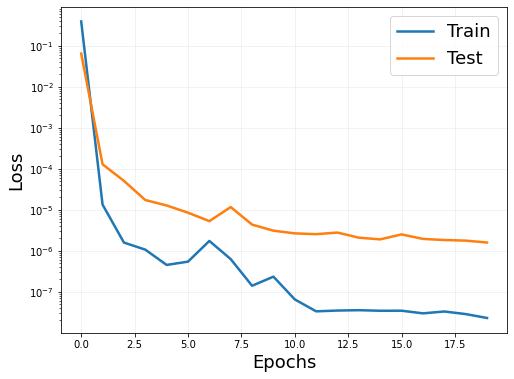

In [49]:
plt.figure(figsize=(8,6))
plt.plot(train_loss, label="Train", linewidth=2.5)
plt.plot(test_loss, label="Test", linewidth=2.5)
plt.grid("on", alpha=0.2)
plt.legend(fontsize=18)
plt.yscale("log")
plt.xlabel("Epochs", fontsize=18)
plt.ylabel("Loss", fontsize=18)
plt.show()

# Evaluating Results

In [50]:
def rmse(true, pred):
    return (((true-pred)**2).mean()**0.5).detach().cpu().numpy()

def l2_error(true, pred):
    return np.linalg.norm(pred.detach().cpu().numpy() - true.detach().cpu().numpy()) / np.linalg.norm(true.detach().cpu().numpy()) 

def compute_metrics(model, loader, mean=0.0, std=1.0):
    model.eval()
    y_ = []
    pred_ = []
    mean = torch.tensor(mean).to(device)
    std = torch.tensor(std).to(device)
    for x, y in iter(loader):
        x, y = x.to(device).float(), y.to(device).float()
        pred = model(x)
        y = y * std + mean
        pred = pred * std + mean
        y_.append(y)
        pred_.append(pred)
    y_ = torch.cat(y_, dim=0) 
    pred_ = torch.cat(pred_, dim=0)
    
    rmse_temp = rmse(y_[:,0], pred_[:,0])
    
    l2_error_temp = l2_error(y_[:,0], pred_[:,0])
    return rmse_temp, l2_error_temp

In [51]:
rmse_temp, l2_error_temp = compute_metrics(model, test_loader,  mean = output_mean, std = output_std)
print(f"Test Rmse of Temp: {rmse_temp}")
print(f"L2 Error  of Temp: {l2_error_temp}")

Test Rmse of Temp: 0.008585327057951142
L2 Error  of Temp: 0.0005240983533874755


In [52]:
rmse_temp, l2_error_temp = compute_metrics(model, train_loader,  mean = output_mean, std = output_std)
print(f"Train Rmse of Temp: {rmse_temp}")
print(f"L2 Error  of Temp: {l2_error_temp}")

Train Rmse of Temp: 0.001191915620761876
L2 Error  of Temp: 8.38811354140926e-05


# Saving Model

In [53]:
PATH = f"./saved_models/ice_model_time.pth"
torch.save(model.state_dict(), PATH)

In [54]:
output_mean

array([12.46821208])